## Tutorial to run DeepKoopman on NACA0012 data
We will walk through a tutorial on predicting the $200$-dimensional pressure vector $x$ across the surface of a [NACA0012 airfoil](https://en.wikipedia.org/wiki/NACA_airfoil) at varying angles of attack $t$.

In [1]:
from deepk.core import DeepKoopman
from deepk import utils

### Load data

In [2]:
import pickle
with open('./data.pkl', 'rb') as f:
    data = pickle.load(f)

The resulting `data` dictionary is documented [here](https://galoisinc.github.io/deep-koopman/core.html#deepk.core.DeepKoopman). Its contents are:
- `'ttr': range(15)`. Angle of attack values used for training. Note that the training indices must be in ascending order and should ideally be equally spaced.
- `'Xtr'` of shape `(15,200)`. Each row is the 200-dimensional pressure vector $x$ for the corresponding angle of attack (i.e. `Xtr[0]` corresponds to $x_0$).
- `'tva': [0.5,3.5,4.5,7.5,16,17,20]`, and `'tte': [1.5,2.5,5.5,6.5,15,18,19]`. Angle of attack values used for validating and testing the neural net, respectively. Note that these indices can be anything, order and spacing is not important.
- `'Xva'` and `'Xte'`. Pressure vectors corresponding to `'tva'` and `'tte'` (i.e. `Xva[0]` corresponds to $x_{0.5}$, `Xte[-1]` corresponds to $x_{19}$, etc).

The following is an optional step used to seed the run. Since neural nets initialize their parameters randomly, setting the same random seed will ensure that your results are exactly the same as this tutorial.

In [3]:
utils.set_seed(10)

### Create DeepKoopman object
The `DeepKoopman` object is documented [here](https://galoisinc.github.io/deep-koopman/core.html#deepk.core.DeepKoopman).

In [4]:
dk = DeepKoopman(
    data = data,
    rank = 6,
    num_encoded_states = 50
)

Deep Koopman log file = /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_7xBa6xaWTEn3f54StygYVT.log


The `rank` is $6$, i.e. the Koopman matrix will be of dimension $6\times6$ (for more on `rank`, see [`koopman_theory.pdf`](../../koopman_theory.pdf)). The encoded vector $g(x)$ will be $50$-dimensional. Since by default `encoder_hidden_layers = [100]`, the overall network looks like:
<figure><center>
<img src="nn_architecture.png" width=480/>
</center></figure>

### Training and testing
This uses all the default training settings, which can be found [here](https://galoisinc.github.io/deep-koopman/core.html#deepk.core.DeepKoopman).

In [6]:
dk.train_net()
dk.test_net()

100%|██████████| 500/500 [00:06<00:00, 81.43it/s]


### Visualizing results
Let's plot:
- The [MSE loss](https://galoisinc.github.io/deep-koopman/losses.html#deepk.losses.mse) for the prediction task.
- The [overall loss](https://galoisinc.github.io/deep-koopman/losses.html#deepk.losses.overall), which is a linear combination of different losses that is optimized during training via gradient descent.
- The prediction [average normalized absolute error (ANAE)](https://galoisinc.github.io/deep-koopman/errors.html#deepk.errors.anae), which is a measure of the relative error between $x$ and $\hat{x}'$.

Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_7xBa6xaWTEn3f54StygYVT_pred_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_7xBa6xaWTEn3f54StygYVT_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_7xBa6xaWTEn3f54StygYVT_pred_anae.png


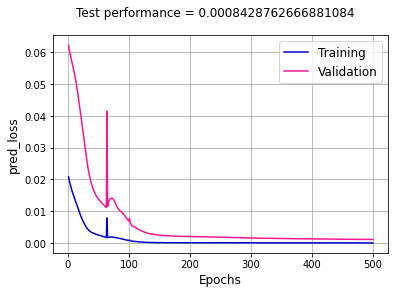

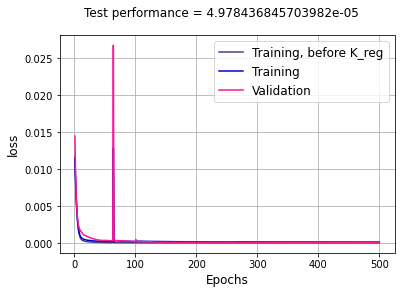

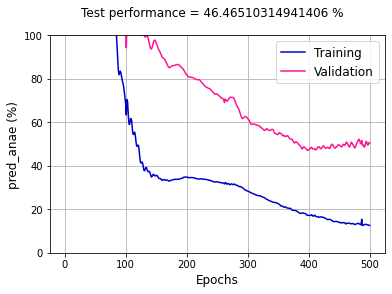

In [7]:
utils.plot_stats(dk, ['pred_loss', 'loss', 'pred_anae'])

Despite a spike early on in training (potentially due to numerical instabilities), `loss` and `pred_loss` go down as expected and the final losses on test data are low. However, `pred_anae` on test data is $\sim46\%$, which isn't great, but also isn't surprising since we didn't optimize the training at all.

Let's see if we can do better.

### Optimizing
Let's tweak the settings and re-run.

  0%|          | 3/1000 [00:00<00:36, 27.68it/s]

Deep Koopman log file = /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_hUHBSqTPLfDvFqiyDPZ8ut.log


100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]


Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_hUHBSqTPLfDvFqiyDPZ8ut_pred_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_hUHBSqTPLfDvFqiyDPZ8ut_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_hUHBSqTPLfDvFqiyDPZ8ut_pred_anae.png


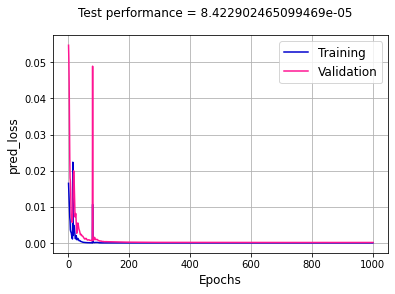

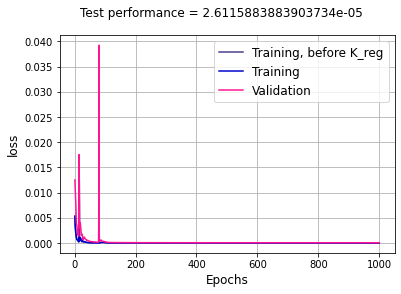

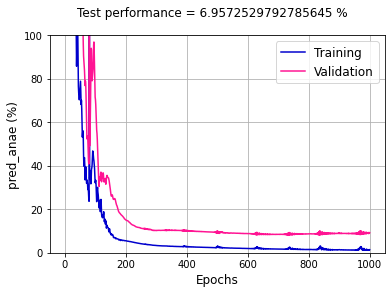

In [9]:
utils.set_seed(10)

dk = DeepKoopman(
    data = data,
    rank = 6,
    num_encoded_states = 500,
    encoder_hidden_layers = [1000,500],
    numepochs = 1000,
    decoder_loss_weight = 0.1,
    K_reg = 0.,
    clip_grad_value = 2.
)

dk.train_net()
dk.test_net()

utils.plot_stats(dk, ['pred_loss', 'loss', 'pred_anae'])

The `pred_anae` on test data is now an impressive $6.95\%$, indicating that one can expect any predictions $x$ for some unknown $t$ to be within $7\%$ of the actual values.

### Improving run time
The above network might have taken close to a minute to train. Let's try stopping training early if the validation `pred_anae` does not improve for 50 epochs.

  0%|          | 3/1000 [00:00<00:40, 24.92it/s]

Deep Koopman log file = /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_ZoSijxWTWZ9uxJ6pAeVB9x.log


 56%|█████▌    | 555/1000 [00:19<00:15, 28.50it/s]


Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_ZoSijxWTWZ9uxJ6pAeVB9x_pred_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_ZoSijxWTWZ9uxJ6pAeVB9x_loss.png
Saving figure /Users/sourya/work/Essence/deep-koopman/examples/naca0012/dk_ZoSijxWTWZ9uxJ6pAeVB9x_pred_anae.png


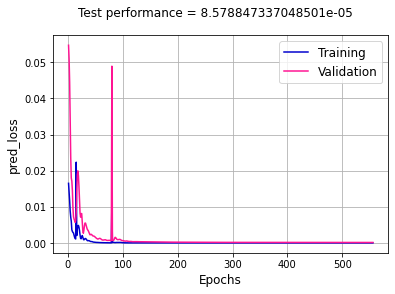

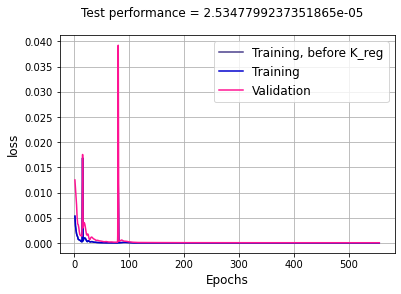

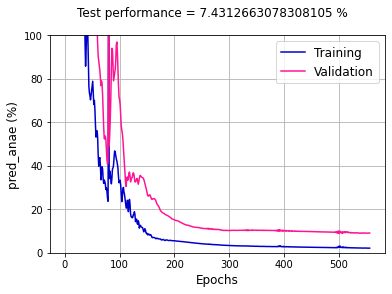

In [10]:
utils.set_seed(10)

dk = DeepKoopman(
    
    ## Same settings as before
    data = data,
    rank = 6,
    num_encoded_states = 500,
    encoder_hidden_layers = [1000,500],
    numepochs = 1000,
    decoder_loss_weight = 0.1,
    K_reg = 0.,
    clip_grad_value = 2.,

    ## New settings
    early_stopping = 50,
    early_stopping_metric = 'pred_anae'
)

dk.train_net()
dk.test_net()

utils.plot_stats(dk, ['pred_loss', 'loss', 'pred_anae'])

Training is now faster, and stops after 555 epochs. The `pred_anae` on test data is slightly higher than before at $7.43\%$.

### Unknown state predictions
Let's use the trained DeepKoopman model to print predictions for $x_{3.75}$ and $x_{21}$, i.e. the unknown $200$-dimensional pressure vectors for angles of attack $3.75^{\circ}$ and $21^{\circ}$. Note that one of these $t$ values is in between the available $t$ values $3.5$ and $4$, while the other is beyond the available $t$ values. This demonstrates Deep Koopman's ability to perform *interpolation* and *extrapolation*.

In [11]:
dk.predict_new([3.75,21])

tensor([[ 2.9800e-01,  2.1239e-01,  1.8456e-01,  1.6356e-01,  1.4928e-01,
          1.3652e-01,  1.2209e-01,  1.1489e-01,  1.0724e-01,  9.9882e-02,
          9.2997e-02,  8.3977e-02,  7.8498e-02,  7.2773e-02,  6.6075e-02,
          5.9416e-02,  5.6149e-02,  5.1409e-02,  4.7045e-02,  4.3924e-02,
          3.8396e-02,  3.3760e-02,  2.9491e-02,  2.9445e-02,  2.1060e-02,
          2.2643e-02,  1.6566e-02,  1.2795e-02,  1.2286e-02,  8.1408e-03,
          3.8048e-03,  2.8320e-03, -1.6762e-03, -3.0922e-03, -7.2604e-03,
         -5.3711e-03, -9.5780e-03, -1.1859e-02, -1.5789e-02, -1.5730e-02,
         -2.1322e-02, -2.2409e-02, -2.0639e-02, -2.4832e-02, -2.6774e-02,
         -3.0384e-02, -3.3750e-02, -3.3789e-02, -3.4268e-02, -3.8729e-02,
         -3.8699e-02, -3.9703e-02, -4.4543e-02, -4.2319e-02, -4.2541e-02,
         -4.5359e-02, -4.5184e-02, -4.7451e-02, -4.8694e-02, -4.8315e-02,
         -4.7517e-02, -4.6338e-02, -4.7174e-02, -4.6365e-02, -4.5498e-02,
         -4.4083e-02, -4.0318e-02, -3.